**Jupyter Notebook illustrating first iteration of ISIMIP implementation integrated with default set of evaluation metrics**

In [1]:
import sys
sys.path.append("../")  # path contains python_file.py

In [2]:
from PACKAGE_NAME.evaluate import evaluation_functions
import iris
import numpy as np
import scipy
import matplotlib.pyplot as plt

/Users/fionaspuler/opt/anaconda3/lib/python3.9/site-packages/libpysal/weights/util.py:23: UserWarning: geopandas not available. Some functionality will be disabled.
  warn("geopandas not available. Some functionality will be disabled.")


**Set variables to investigate**

In [3]:
variables = ['tas']

# Data import and pre-processing

In [4]:
from cf_units import num2date

def get_dates(x):
    time_dimension = x.coords()[2]
    dates = time_dimension.units.num2date(time_dimension.points)
    return dates

def preprocess_isimip_evaluation_testing_data(variable):
    
    obs_all = iris.load_cube("testing_data/ISIMIP/"+variable+"_obs-hist_coarse_1979-2014.nc")
    cm = iris.load_cube("testing_data/ISIMIP/"+variable+"_sim-hist_coarse_1979-2014.nc")
    
    obs = obs_all[:, :, 0:9000]
    obs_validate = obs_all[:, :, 9001:]
    cm_hist = cm[:, :, 0:9000]
    cm_future = cm[:, :, 9001:]

    dates = {
        "obs": get_dates(obs),
        "obs_validate": get_dates(obs_validate),
        "cm_hist": get_dates(cm_hist),
        "cm_future": get_dates(cm_future),
    }
    
    obs = np.transpose(np.array(obs.data), (2, 0, 1))
    obs_validate = np.transpose(np.array(obs_validate.data), (2, 0, 1))
    cm_hist = np.transpose(np.array(cm_hist.data), (2, 0, 1))
    cm_future = np.transpose(np.array(cm_future.data), (2, 0, 1))
    
    return obs, obs_validate, cm_hist, cm_future, dates


In [5]:
tas_obs, tas_obs_validate, tas_cm_hist, tas_cm_future, tas_dates = preprocess_isimip_evaluation_testing_data('tas')
pr_obs, pr_obs_validate, pr_cm_hist, pr_cm_future, pr_dates = preprocess_isimip_evaluation_testing_data('pr')

In [6]:
# TODO maybe put this into other file...
standard_variables_isimip = {
        "tas": {
        "lower_bound": -np.inf,
        "lower_threshold": -np.inf,
        "upper_bound": np.inf,
        "upper_threshold": np.inf,
        "distribution": scipy.stats.norm,
        "trend_preservation": "additive",
        "detrending": True,
        "name": '2m daily mean air temperature (K)',
        "high_threshold": 295,
        "low_threshold": 273,
        "unit": 'K'
    },
    "pr": {
        "lower_bound": 0,
        "lower_threshold": 0.1 / 86400,
        "upper_bound": np.inf,
        "upper_threshold": np.inf,
        "distribution": scipy.stats.gamma,
        "trend_preservation": "mixed",
        "detrending": False,
        "name": 'Total precipitation (m/day)',
        "high_threshold": 0.0004,
        "low_threshold": 0.00001,
        "unit": 'm/day'
    }
}

# Evaluation phase 1 - test assumptions

## Goodness of fit

In [7]:
tas_obs_aic = evaluation_functions.goodness_of_fit_aic(variable = 'tas', dataset = tas_obs)
print('AIC fit observed data:', tas_obs_aic)

tas_cm_future_aic = evaluation_functions.goodness_of_fit_aic(variable = 'tas', dataset = tas_cm_future)
print('AIC fit CM (validation set):', tas_cm_future_aic)

tas_cm_hist_aic = evaluation_functions.goodness_of_fit_aic(variable = 'tas', dataset = tas_cm_hist)
print('AIC fit CM (training set):', tas_cm_hist_aic)

AIC fit observed data: [61383.86888907 62163.89158525 61794.24825302 62514.2609475 ]
AIC fit CM (validation set): [28999.99154656 28993.24476635 29193.49505323 29230.60955217]
AIC fit CM (training set): [63293.09781318 63411.74856335 63666.59771774 63945.68633789]


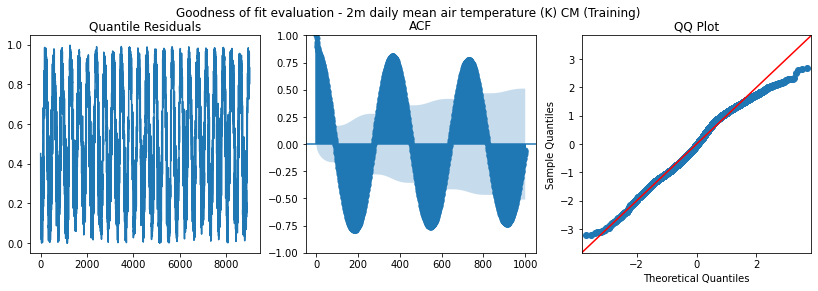

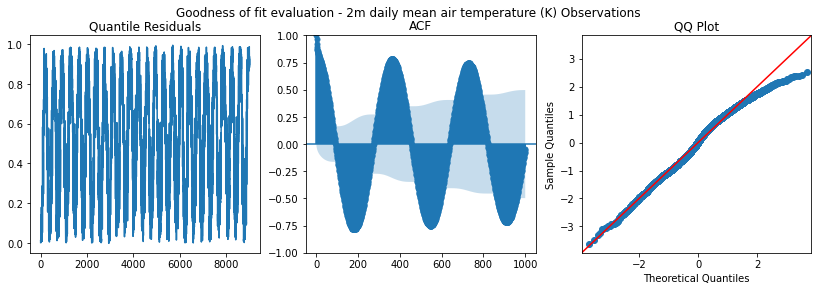

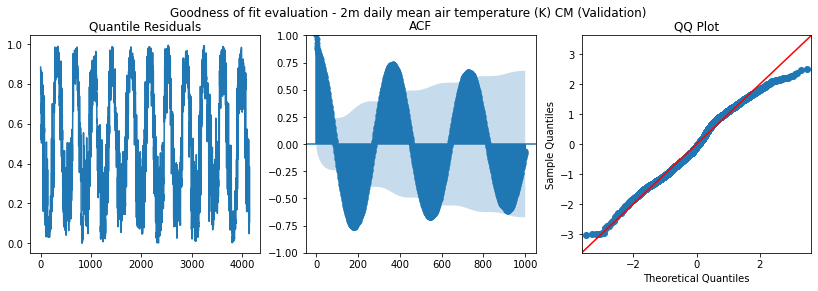

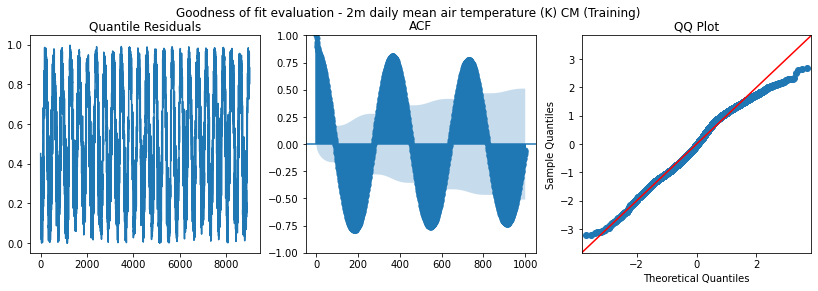

In [8]:
tas_obs_plot_gof = evaluation_functions.goodness_of_fit_plot(dataset = tas_obs[:,0,0], 
                                                        variable = 'tas', data_type = 'Observations')
tas_obs_plot_gof

tas_cm_future_plot_gof = evaluation_functions.goodness_of_fit_plot(dataset = tas_cm_future[:,0,0], 
                                                        variable = 'tas', data_type = 'CM (Validation)')
tas_cm_future_plot_gof

tas_cm_hist_plot_gof = evaluation_functions.goodness_of_fit_plot(dataset = tas_cm_hist[:,0,0], 
                                                        variable = 'tas', data_type = 'CM (Training)')
tas_cm_hist_plot_gof

## Stationarity

In [18]:
from statsmodels.tsa.stattools import adfuller


def stationarity_adf(dataset):

    adf = np.array([])

    for i in range(dataset.shape[1]):
        for j in range(dataset.shape[2]):
            adf = np.append(adf, adfuller(tas_obs[:, i,j])[1])
            
    return(max(adf))

test = stationarity_adf(tas_cm_hist)
test

1.700113108062837e-07

# Apply de-biasers

In [33]:
# from scipy.stats import norm, laplace - not sure I need this
from PACKAGE_NAME.debias import QuantileDeltaMapping, ISIMIP, QuantileMapping
from scipy.stats import norm, laplace
from PACKAGE_NAME.variables import Temperature, Precipitation

In [34]:
QDM_tas_debiaser = QuantileDeltaMapping(distribution=norm, time_window_length=50)
QM_tas_debiaser = QuantileMapping.from_variable(variable=Temperature, delta_type="additive")

QDM_pr_debiaser = QuantileDeltaMapping.from_variable(variable=Precipitation)
QM_pr_debiaser = QuantileMapping.for_precipitation(delta_type = "multiplicative", precipitation_model_type = "censored", precipitation_censoring_value = 0.1)

In [35]:
tas_debiased_QDM = QDM_tas_debiaser.apply(tas_obs, tas_cm_hist, tas_cm_future)
tas_debiased_QM = QM_tas_debiaser.apply(tas_obs, tas_cm_hist, tas_cm_future)

pr_debiased_QDM = QDM_pr_debiaser.apply(pr_obs, pr_cm_hist, pr_cm_future)
pr_debiased_QM = QM_pr_debiaser.apply(pr_obs, pr_cm_hist, pr_cm_future)

----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]/Users/fionaspuler/Documents/GitHub/isimipy/notebooks/../PACKAGE_NAME/debias/_quantile_delta_mapping.py:128: RuntimeWarning: invalid value encountered in true_divide
  cm_future_time_window
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00, 54.24it/s]


----- Running debiasing -----


100%|████████████████████████████████████████████| 4/4 [00:00<00:00, 787.85it/s]


----- Running debiasing -----


  0%|                                                     | 0/4 [00:00<?, ?it/s]/Users/fionaspuler/Documents/GitHub/isimipy/notebooks/../PACKAGE_NAME/utils/_math_utils.py:330: RuntimeWarning: invalid value encountered in log
  return -np.sum(scipy.stats.gamma.logpdf(x, a=params[0], scale=params[1])) - nr_censored_x * np.log(
100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.09it/s]


----- Running debiasing -----


100%|█████████████████████████████████████████████| 4/4 [00:00<00:00,  9.75it/s]


# Evaluation of bias corrected results on validation period

## Marginal Aspects

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_17140/1223852072.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure_marginal_boxplot.show()
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_17140/1223852072.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure_hist.show()
/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_17140/1223852072.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  figure_bias_map.show()


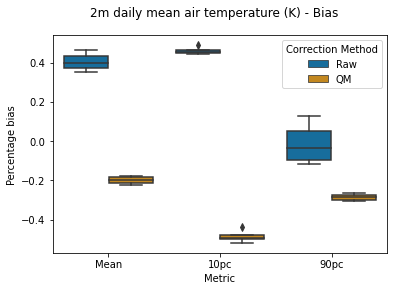

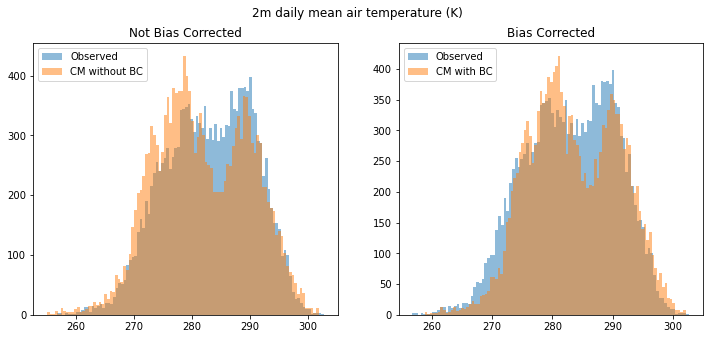

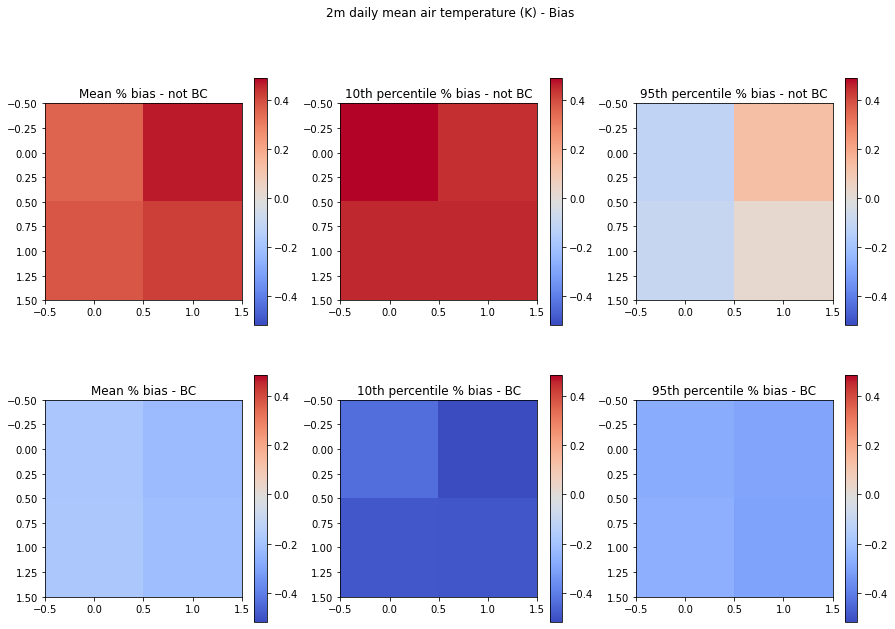

In [13]:
# overview boxplot
figure_marginal_boxplot = evaluation_functions.marginal_bias_boxplot('tas', tas_obs_validate, tas_cm_future, tas_debiased_QM, 'QM')
figure_marginal_boxplot.show()

# histogram over entire area
figure_hist = evaluation_functions.histogram_plot('tas', np.ndarray.flatten(tas_obs_validate), np.ndarray.flatten(tas_cm_future), 
                    np.ndarray.flatten(tas_debiased_QM))
figure_hist.show()

# spatial distribution of bias
figure_bias_map = evaluation_functions.marginal_bias_plot('tas', tas_obs_validate, tas_cm_future, tas_debiased_QM)
figure_bias_map.show()

## Climate change indices - extreme / exceedance over threshold analysis

### Marginal

In [14]:
# calculate probability of threshold exceedance
tas_obs_highEOT_probability = evaluation_functions.EOT_calculate_probability(variable = 'tas', 
                                                                        data = tas_obs_validate, 
                                                                        thresholdname = 'high_threshold', 
                                                                        thresholdsign = '>')
tas_obs_lowEOT_probability = evaluation_functions.EOT_calculate_probability(variable = 'tas', 
                                                                        data = tas_obs_validate, 
                                                                        thresholdname = 'low_threshold', 
                                                                        thresholdsign = '<')
tas_cm_highEOT_probability = evaluation_functions.EOT_calculate_probability(variable = 'tas', 
                                                                        data = tas_cm_future, 
                                                                        thresholdname = 'high_threshold', 
                                                                        thresholdsign = '>')
tas_cm_lowEOT_probability = evaluation_functions.EOT_calculate_probability(variable = 'tas', 
                                                                        data = tas_cm_future, 
                                                                        thresholdname = 'low_threshold', 
                                                                        thresholdsign = '<')
tas_QM_highEOT_probability = evaluation_functions.EOT_calculate_probability(variable = 'tas', 
                                                                        data = tas_debiased_QM, 
                                                                        thresholdname = 'high_threshold', 
                                                                        thresholdsign = '>')
tas_QM_lowEOT_probability = evaluation_functions.EOT_calculate_probability(variable = 'tas', 
                                                                        data = tas_debiased_QM, 
                                                                        thresholdname = 'low_threshold', 
                                                                        thresholdsign = '<')

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_17140/2141620464.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  EOT_boxplot.show()


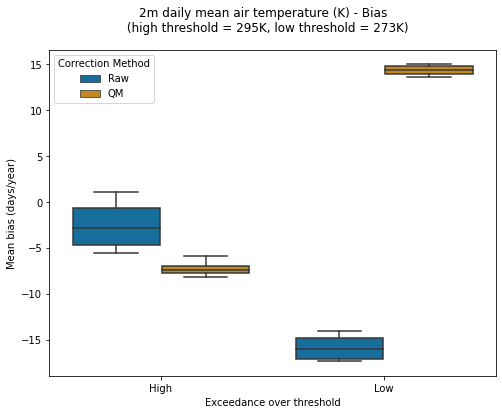

In [15]:
# plot spatial distribution of mean bias in days
EOT_boxplot = evaluation_functions.EOT_mean_bias_days_boxplot(variable = 'tas', name_BC = 'QM', 
                                  high_obs = tas_obs_highEOT_probability, 
                                  low_obs = tas_obs_lowEOT_probability, 
                                  high_raw = tas_cm_highEOT_probability, 
                                  low_raw = tas_cm_lowEOT_probability, 
                                  high_bc = tas_QM_highEOT_probability, 
                                  low_bc = tas_QM_lowEOT_probability)
EOT_boxplot.show()

### Temporal

High 2m daily mean air temperature (K) spell-length - Observations compared to Raw CM 
 KS-test 
 Maximum distance between cdf functions: 0.1125 
 p-value = 0.5599166924771006
There is an absence of evidence to conclude that the two samples were not drawn from the same distribution. 

Low 2m daily mean air temperature (K) spell-length - Observations compared to Raw CM 
 KS-test 
 Maximum distance between cdf functions: 0.11037037037037037 
 p-value = 0.11110219596517001
There is an absence of evidence to conclude that the two samples were not drawn from the same distribution. 

High 2m daily mean air temperature (K) spell-length - Observations compared to debiased CM (QM) 
 KS-test 
 Maximum distance between cdf functions: 0.17738549618320612 
 p-value = 0.07550505988611944
There is an absence of evidence to conclude that the two samples were not drawn from the same distribution. 

Low 2m daily mean air temperature (K) spell-length - Observations compared to deabised CM (QM) 
 KS-test 

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_20966/3149413845.py:3: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  tas_spell_lenth_plot.show()


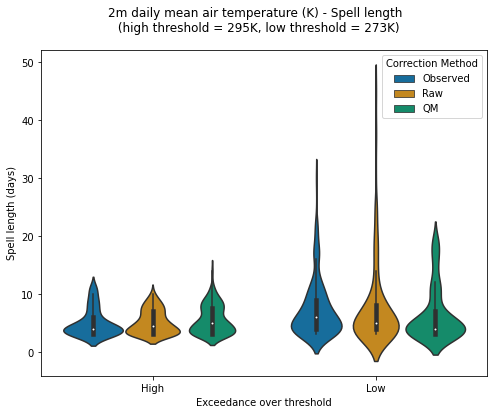

In [38]:
tas_spell_length_plot = evaluation_functions.EOT_spell_length_violinplot(variable = 'tas', data_obs = tas_obs_validate, data_raw = tas_cm_future,
                                data_bc = tas_debiased_QM, name_BC = 'QM', minimum_spell_length = 2)
tas_spell_length_plot.show()

### Spatial

Compute percent of gridcell above / below threshold, if one cell is above/below threshold - this should give a distribution that signifies co-occurence

In [39]:
# spatial clusters
tas_spatial_clusters = evaluation_functions.EOT_spatial_compounding(variable = 'tas', name_BC = 'QM', 
                                                                    data_obs = tas_obs_validate, 
                                                                    data_raw = tas_cm_future, 
                                                                    data_bc = tas_debiased_QM)
    
tas_spatial_clusters_plot = evaluation_functions.clusters_violinplot('tas', tas_spatial_clusters, clustertype = 'spatial')
tas_spatial_clusters_plot.show()

### Spatio-temporal clustering

/var/folders/3g/80lqcgbn19l711ck1nnjxplr0000gn/T/ipykernel_20966/4080615324.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  spatiotemporal_clusters_plot.show()


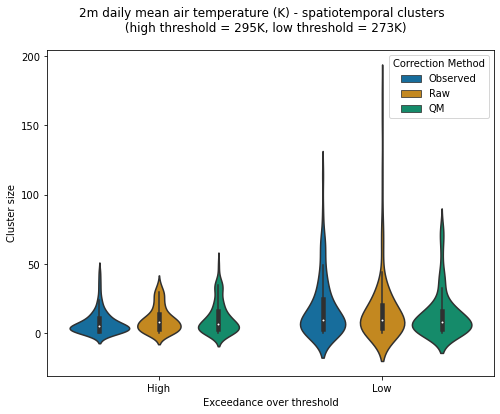

In [37]:
# spatiotemporally connected clusters
tas_spatiotemporal_clusters = evaluation_functions.calculate_spatiotemporal_clusters(variable = 'tas', name_BC = 'QM', 
                                         data_obs = tas_obs_validate, 
                                         data_raw = tas_cm_future, 
                                         data_bc = tas_debiased_QM)
tas_spatiotemporal_clusters

tas_spatiotemporal_clusters_plot = evaluation_functions.clusters_violinplot('tas', tas_spatiotemporal_clusters, 'spatiotemporal')
tas_spatiotemporal_clusters_plot.show()

## Spatial correlation

Implement that mean RMSD that I had done in the google colab, don't think too much about it...

## Trend preservation

# Conclusion